In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import os
import sys
import copy
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
import torchvision.transforms as transforms

from IPython.display import display

sys.path.append('../../src/')
import modeling_utils
import models
import optimization_utils

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.4.0'

## Hyperparamaters

In [4]:
NOISE_SIZE = 128
GRAD_PEN_WEIGHT = 10
MAX_DEPTH = 5
FADE_IN_PCT = .5
NB_EPOCHS = 5
SAMPLE_INTERVAL = 256
IMG_SIZE = 64
BATCH_SIZES = [128, 128, 64, 64, 32]

## Load the data, and get some information from it

In [5]:
data_transform = transforms.Compose([transforms.ToTensor()])

In [6]:
sizes = [2**i for i in range(2, int(1+np.log(IMG_SIZE) / np.log(2)))]

In [7]:
sizes

[4, 8, 16, 32, 64]

In [8]:
BATCH_SIZES = {size : bs for size, bs in zip(sizes, BATCH_SIZES)}

In [9]:
img_path = '../../data/modeling_%d/images/'
label_dicts = {size : {i: img_path%size + f for i, f in enumerate(os.listdir(img_path%size))} for size in sizes}

In [10]:
datasets = {}
for k, v in label_dicts.items():
    datasets[k] = modeling_utils.BirdDataset(v, transform=data_transform)

In [11]:
data_loaders = {}
for k, v in label_dicts.items():
    data_loaders[k] = torch.utils.data.DataLoader(datasets[k], batch_size=BATCH_SIZES[k], num_workers=0, shuffle=True)

0.0 1.0


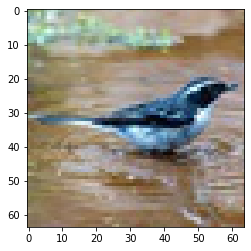

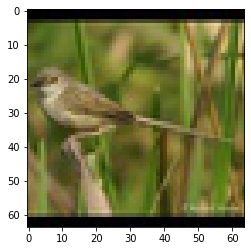

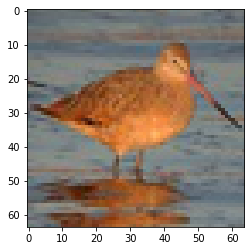

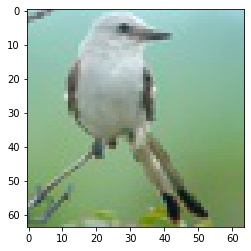

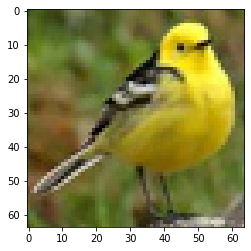

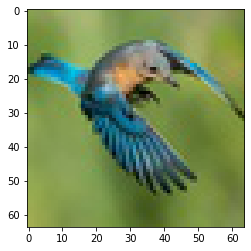

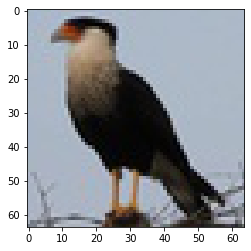

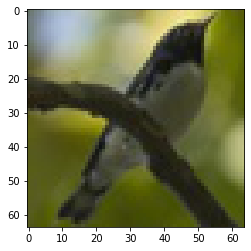

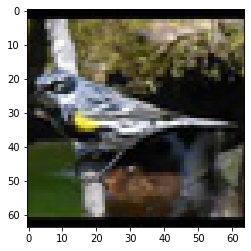

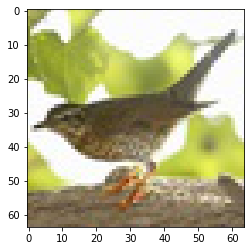

In [12]:
for batch in data_loaders[64]:
    batch = modeling_utils.swap_channels_batch(batch.data.cpu().numpy())
    print(batch.min(), batch.max())
    for i in range(10):
        plt.imshow(batch[i])
        plt.show()
    break

In [13]:
device = torch.device('cuda')

In [ ]:
FIXED_NOISE = modeling_utils.generate_noise(16, NOISE_SIZE, device)

In [15]:
FIXED_NOISE[0].size(), FIXED_NOISE[1].size()

(torch.Size([128]), torch.Size([128]))

### Models themselves

In [16]:
gen = models.ProGanGenerator(depth=MAX_DEPTH, noise_size=NOISE_SIZE).to(device)
gen_opt = optim.Adam(gen.parameters(), betas=(0, .99))
gen_ema = copy.deepcopy(gen)
optimization_utils.update_average(gen_ema, gen, 0)

In [17]:
discrim = models.ProGanDiscriminator(depth=MAX_DEPTH, noise_size=NOISE_SIZE).to(device)
discrim_opt = optim.Adam(discrim.parameters(), betas=(0, .99))

In [18]:
gen(modeling_utils.generate_noise(32, NOISE_SIZE, device=device), 4,0).size()

torch.Size([32, 3, 64, 64])

In [19]:
discrim(gen(modeling_utils.generate_noise(32, NOISE_SIZE, device=device), 0,0), 0, 0).size()

torch.Size([32])

### Optimization steps

In [20]:
# save_path = './' + datetime.datetime.now().strftime('%m-%d_%H-%M') + '/'
save_path = './progan_first_pass/'

In [21]:
optimization_utils.train_on_depth_wasserstein_gp(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=0, nb_epochs=5, 
                                                fade_in_pct=FADE_IN_PCT, loader = data_loaders[4], device=device, 
                                                 noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, checkpoint_interval=.25,
                                                 save_dir=save_path, 
                                                 print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
                                                 save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False)

In [22]:
NB_EPOCHS = 10

In [23]:
optimization_utils.train_on_depth_wasserstein_gp(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=1, nb_epochs=10, 
                                                fade_in_pct=FADE_IN_PCT, loader = data_loaders[8], device=device, 
                                                 noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, checkpoint_interval=.25,
                                                 save_dir=save_path, 
                                                 print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
                                                 save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False)

In [24]:
optimization_utils.train_on_depth_wasserstein_gp(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=2, nb_epochs=10, 
                                                fade_in_pct=FADE_IN_PCT, loader = data_loaders[16], device=device, 
                                                 noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, checkpoint_interval=.25,
                                                 save_dir=save_path, 
                                                 print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
                                                 save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False)

In [25]:
optimization_utils.train_on_depth_wasserstein_gp(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=3, nb_epochs=10, 
                                                fade_in_pct=FADE_IN_PCT, loader = data_loaders[32], device=device, 
                                                 noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, checkpoint_interval=.25,
                                                 save_dir=save_path, 
                                                 print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
                                                 save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False)

In [ ]:
optimization_utils.train_on_depth_wasserstein_gp(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=4, nb_epochs=10, 
                                                fade_in_pct=FADE_IN_PCT, loader = data_loaders[64], device=device, 
                                                 noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, checkpoint_interval=.25,
                                                 save_dir=save_path, 
                                                 print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
                                                 save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False)